In [1]:
import uproot
import numpy as np
import glob
import os
import sys
import pandas as pd
import tensorflow as tf
import matplotlib.pyplot as plt
from matplotlib.colors import LogNorm
from sklearn.model_selection import train_test_split
from sklearn.metrics import roc_curve, auc, accuracy_score
import tensorflow.keras.backend as K
from sklearn.preprocessing import StandardScaler, LabelEncoder
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.layers import *
from tensorflow import keras
from tensorflow.keras import layers, models, Model

np.random.seed(42)
tf.random.set_seed(42)

In [2]:
file = uproot.open('datasets/merged_HHbbbb_10000_0_train.root')
tree = file['CaloTree']
data = tree.arrays(library="np")

In [3]:
for branch, array in data.items():
    print(f"{branch}")

ncell_isHS
cell_isHS
ncell_et
cell_et
ncell_x
cell_x
ncell_y
cell_y
ncell_z
cell_z
ncell_sampling
cell_sampling
ncell_topo
cell_topo
EventNumber
nEventWeight
EventWeight
nTruthJets_pt
TruthJets_pt
nTruthJets_eta
TruthJets_eta
nTruthJets_phi
TruthJets_phi
nTruthPartons_VtxZ
TruthPartons_VtxZ
nTruthPartons_pt
TruthPartons_pt
nTruthPartons_eta
TruthPartons_eta
nTruthPartons_phi
TruthPartons_phi
ncell_4sig
cell_4sig


In [4]:
def compute_eta_phi(x, y, z):
    phi = np.arctan2(y, x)
    p = np.sqrt(x**2 + y**2 + z**2)
    eta = 0.5 * np.log((p + z) / (p - z))
    return eta, phi

eta_list = []
phi_list = []

for x_arr, y_arr, z_arr in zip(data['cell_x'], data['cell_y'], data['cell_z']):
    eta, phi = compute_eta_phi(x_arr, y_arr, z_arr)
    eta_list.append(eta)
    phi_list.append(phi)

data['cell_eta'] = np.array(eta_list, dtype=object)
data['cell_phi'] = np.array(phi_list, dtype=object)

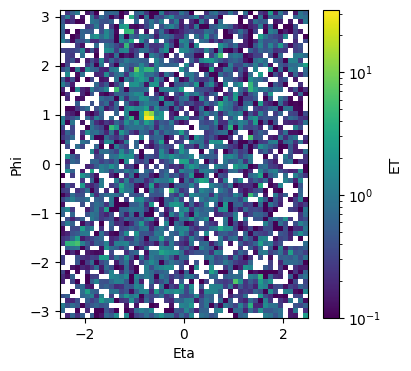

In [5]:
eta_bins = np.arange(-2.5, 2.5 + 0.1, 0.1)
phi_bins = np.arange(-np.pi, np.pi + np.pi/32, np.pi/32)

n = 1

eta_event = data['cell_eta'][n]
phi_event = data['cell_phi'][n]
et_event  = data['cell_et'][n]/1000.

heatmap, eta_edges, phi_edges = np.histogram2d(
    eta_event,
    phi_event,
    bins = [eta_bins, phi_bins],
    weights = et_event
)

plt.figure(figsize = (4, 4))
mesh = plt.pcolormesh(
    eta_edges,
    phi_edges,
    heatmap.T,
    cmap = 'viridis',
    norm = LogNorm(vmin = 1e-1, vmax = np.max(et_event))
)

plt.xlabel('Eta')
plt.ylabel('Phi')
plt.colorbar(mesh, label = 'ET')
plt.show()

In [16]:
n_events = len(data['cell_eta'])

X_isHS = np.zeros((n_events, len(eta_edges)-1, len(phi_edges)-1, 6))
X_isPU = np.zeros((n_events, len(eta_edges)-1, len(phi_edges)-1, 6))

for i in range(n_events):
    cell_eta    = data['cell_eta'][i]
    cell_phi    = data['cell_phi'][i]
    cell_et     = data['cell_et'][i]/1000.
    cell_sampling = data['cell_sampling'][i]
    cell_isHS   = data['cell_isHS'][i]

    abs_eta = np.abs(cell_eta)
    
    cond_ch0 = ((cell_sampling == 0) & (abs_eta < 1.5)) | \
               ((cell_sampling == 4) & (abs_eta > 1.5) & (abs_eta < 1.8))
    
    cond_ch1 = ((cell_sampling == 1) & (abs_eta < 1.5)) | \
               ((cell_sampling == 5) & (abs_eta > 1.5) & (abs_eta < 2.5))
    
    cond_ch2 = ((cell_sampling == 2) & (abs_eta < 1.5)) | \
               ((cell_sampling == 6) & (abs_eta > 1.5) & (abs_eta < 2.5))
    
    cond_ch3 = ((cell_sampling == 3) & (abs_eta < 1.5)) | \
               ((cell_sampling == 7) & (abs_eta > 1.5) & (abs_eta < 2.5))
    
    cond_ch4 = ((cell_sampling == 12) & (abs_eta < 1)) | \
               ((cell_sampling == 18) & (abs_eta > 1.1) & (abs_eta < 1.5)) | \
               ((cell_sampling == 8)  & (abs_eta > 1.5) & (abs_eta < 2.5))
    
    cond_ch5 = ((cell_sampling == 13) & (abs_eta < 0.9)) | \
               ((cell_sampling == 19) & (abs_eta > 1)   & (abs_eta < 1.5)) | \
               ((cell_sampling == 15) & (abs_eta > 0.9) & (abs_eta < 1))   | \
               ((cell_sampling == 9)  & (abs_eta > 1.5) & (abs_eta < 2.5))
    
    conditions = [cond_ch0, cond_ch1, cond_ch2, cond_ch3, cond_ch4, cond_ch5]
    
    for ch in range(6):
        mask = conditions[ch]
        
        hs_mask = mask & (cell_isHS == 1)
        pu_mask = mask & (cell_isHS == 0)
        
        eta_hs = cell_eta[hs_mask]
        phi_hs = cell_phi[hs_mask]
        et_hs  = cell_et[hs_mask]

        hist_hs, _, _ = np.histogram2d(eta_hs, phi_hs, bins=[eta_edges, phi_edges], weights=et_hs)
        
        eta_pu = cell_eta[pu_mask]
        phi_pu = cell_phi[pu_mask]
        et_pu  = cell_et[pu_mask]
        hist_pu, _, _ = np.histogram2d(eta_pu, phi_pu, bins=[eta_edges, phi_edges], weights=et_pu)
        
        X_isHS[i, :, :, ch] = hist_hs
        X_isPU[i, :, :, ch] = hist_pu

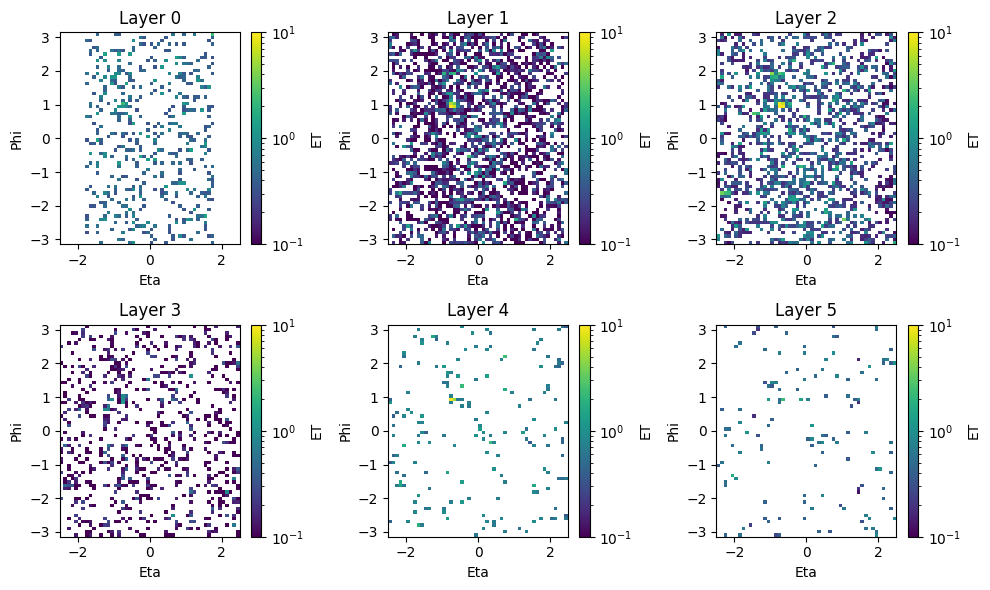

In [30]:
event_idx = 1

fig, axes = plt.subplots(2, 3, figsize=(10, 6))

for ch in range(6):
    ax = axes[ch // 3, ch % 3]
    
    heatmap_data = X_isPU[event_idx, :, :, ch] + X_isHS[event_idx, :, :, ch]
    
    mesh = ax.pcolormesh(eta_edges, phi_edges, heatmap_data.T, cmap='viridis', norm = LogNorm(vmin = 1e-1, vmax = 1e1))
    
    ax.set_xlabel('Eta')
    ax.set_ylabel('Phi')
    ax.set_title(f'Layer {ch}')
    
    fig.colorbar(mesh, ax=ax, label='ET')

plt.tight_layout()
plt.show()

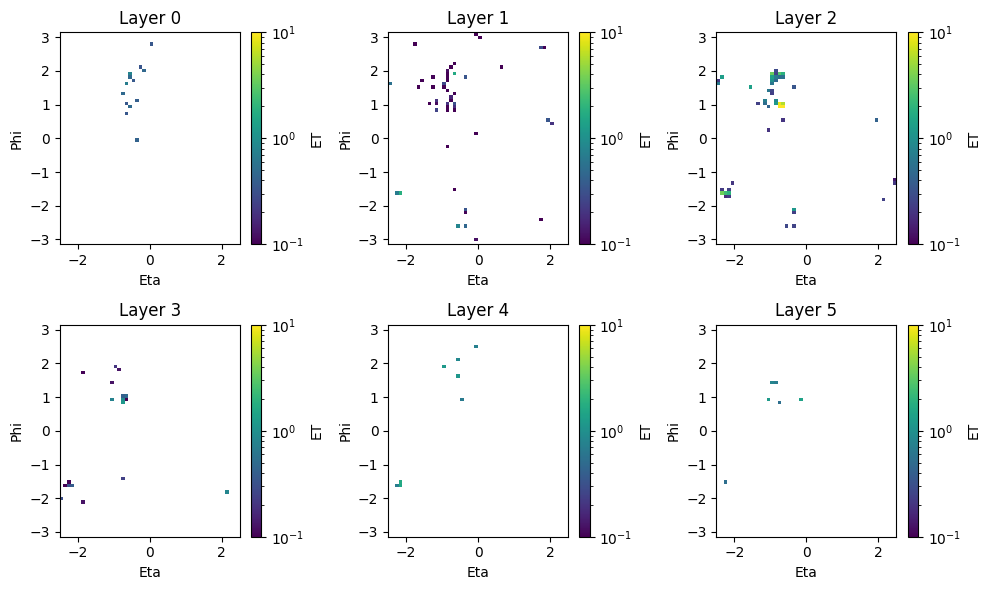

In [32]:
fig, axes = plt.subplots(2, 3, figsize=(10, 6))

for ch in range(6):
    ax = axes[ch // 3, ch % 3]
    
    heatmap_data = X_isHS[event_idx, :, :, ch]
    
    mesh = ax.pcolormesh(eta_edges, phi_edges, heatmap_data.T, cmap='viridis', norm = LogNorm(vmin = 1e-1, vmax = 1e1))
    
    ax.set_xlabel('Eta')
    ax.set_ylabel('Phi')
    ax.set_title(f'Layer {ch}')
    
    fig.colorbar(mesh, ax=ax, label='ET')

plt.tight_layout()
plt.show()